<a href="https://colab.research.google.com/github/hscrown/paper_reading/blob/main/GoogleNet_(Inception_v1)_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 GoogleNet (Inception v1)

In [2]:
# 데이터 전처리
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# CIFAR-10 데이터셋 로드 및 스플릿
(train_X, train_y), (test_X, test_y) = datasets.cifar10.load_data()

# 데이터 정규화 (픽셀 값 범위를 [0, 1]로 변환)
train_X = train_X / 255.0
test_X = test_X / 255.0

# CIFAR-10을 GoogleNet 입력 크기인 224x224로 리사이즈
train_X = tf.image.resize(train_X, [224, 224])
test_X = tf.image.resize(test_X, [224, 224])

# 데이터셋 크기 확인
print("Train data shape:", train_X.shape)  # (50000, 224, 224, 3)
print("Test data shape:", test_X.shape)    # (10000, 224, 224, 3)

170498071/170498071 [==============================] - 3s 0us/step
Train data shape: (50000, 224, 224, 3)
Test data shape: (10000, 224, 224, 3)


In [4]:
# 인셉션 모듈 정의 함수
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 컨볼루션 경로
    path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 1x1 컨볼루션 후 3x3 컨볼루션 경로
    path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)

    # 1x1 컨볼루션 후 5x5 컨볼루션 경로
    path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)

    # 3x3 최대 풀링 후 1x1 컨볼루션 경로
    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)

    # 네 가지 경로를 채널 방향으로 결합하여 인셉션 모듈의 출력 생성
    return layers.concatenate([path1, path2, path3, path4], axis=-1)

# GoogleNet 모델 구축 시작
input_layer = layers.Input(shape=(224, 224, 3))

# 초기 컨볼루션 및 최대 풀링 레이어
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# 두 번째 컨볼루션 및 최대 풀링 레이어
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# 첫 번째 인셉션 모듈 그룹
x = inception_module(x, 64, 96, 128, 16, 32, 32)  # 인셉션 (3a)
x = inception_module(x, 128, 128, 192, 32, 96, 64)  # 인셉션 (3b)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# 두 번째 인셉션 모듈 그룹
x = inception_module(x, 192, 96, 208, 16, 48, 64)  # 인셉션 (4a)
x = inception_module(x, 160, 112, 224, 24, 64, 64)  # 인셉션 (4b)
x = inception_module(x, 128, 128, 256, 24, 64, 64)  # 인셉션 (4c)
x = inception_module(x, 112, 144, 288, 32, 64, 64)  # 인셉션 (4d)
x = inception_module(x, 256, 160, 320, 32, 128, 128)  # 인셉션 (4e)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# 세 번째 인셉션 모듈 그룹
x = inception_module(x, 256, 160, 320, 32, 128, 128)  # 인셉션 (5a)
x = inception_module(x, 384, 192, 384, 48, 128, 128)  # 인셉션 (5b)

# 마지막 단계: Global Average Pooling과 Fully Connected Layer
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(10, activation='softmax')(x)  # CIFAR-10은 10개의 클래스를 가지므로 유닛 수를 10으로 설정

# 모델 정의
model = models.Model(input_layer, x)

# 모델 컴파일
# Adam 옵티마이저와 sparse_categorical_crossentropy 손실 함수를 사용하여 다중 클래스 분류 수행
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 56, 56, 192)          110784    ['max_pooling2d[0][0]']   

In [5]:
# 모델 학습
history = model.fit(train_X, train_y, epochs=5, validation_data=(test_X, test_y))

Epoch 1/5
1563/1563 [==============================] - 829s 525ms/step - loss: 2.3030 - accuracy: 0.0958 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/5
1563/1563 [==============================] - 808s 517ms/step - loss: 2.3028 - accuracy: 0.0987 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/5
1563/1563 [==============================] - 808s 517ms/step - loss: 2.3028 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/5
1563/1563 [==============================] - 806s 516ms/step - loss: 2.3028 - accuracy: 0.0968 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/5
1563/1563 [==============================] - 805s 515ms/step - loss: 2.3028 - accuracy: 0.0958 - val_loss: 2.3026 - val_accuracy: 0.1000


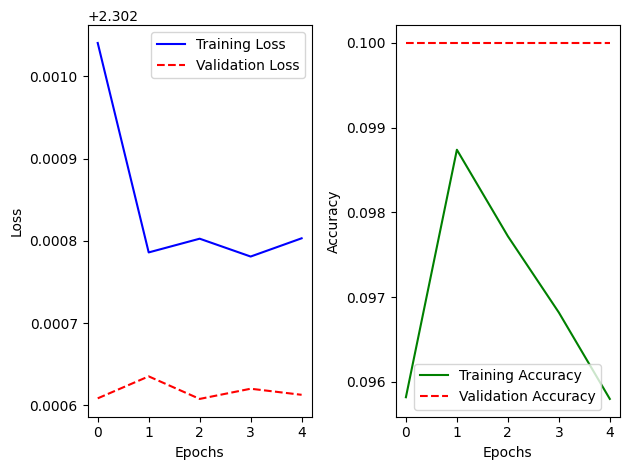

In [6]:
# 결과 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'r--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# 모델 성능 평가
test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 2.302612781524658, Test Accuracy: 0.10000000149011612
